# tsam - Optimal combination of segments and periods for building supply systems 
Date: 29.05.2022

Author: Leander Kotzur

Import pandas and the relevant time series aggregation class

In [1]:
%load_ext autoreload
%autoreload 2
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt
import tsam.timeseriesaggregation as tsam
import tsam.hyperparametertuning as tune
import tqdm
%matplotlib inline

### Input data 

Read in time series from testdata.csv with pandas

In [2]:
raw = pd.read_csv('testdata.csv', index_col = 0)
raw=raw.rename(columns={'T': 'Temperature [°C]', 'Load':'Load [kW]', 'Wind':'Wind [m/s]', 'GHI': 'Solar [W/m²]'})

In [3]:
raw.drop(columns=['Wind [m/s]',], inplace=True)

Create a plot function for a visual comparison of the time series

In [4]:
def plotTS(plot_data, raw_data, periodlength=24):
    fig, axes = plt.subplots(figsize = [7, 6], dpi = 100, nrows = raw_data.shape[1], ncols = 1)
    for i, column in enumerate(raw.columns):
        data = plot_data[column]
        stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(data), periodlength)
        cax = axes[i].imshow(stacked.values.T, interpolation = 'nearest', vmin = raw_data[column].min(), vmax = raw_data[column].max(), origin='lower')
        axes[i].set_aspect('auto')  
        axes[i].set_ylabel('Hour')
        plt.xlabel('Day in the year')

        cbar=plt.colorbar(cax, ax=axes[i], pad=0.01, aspect=7)
        cbar.set_label(column)

    fig.subplots_adjust(right = 1.1, hspace = 0.05)

Plot an example series - in this case the temperature

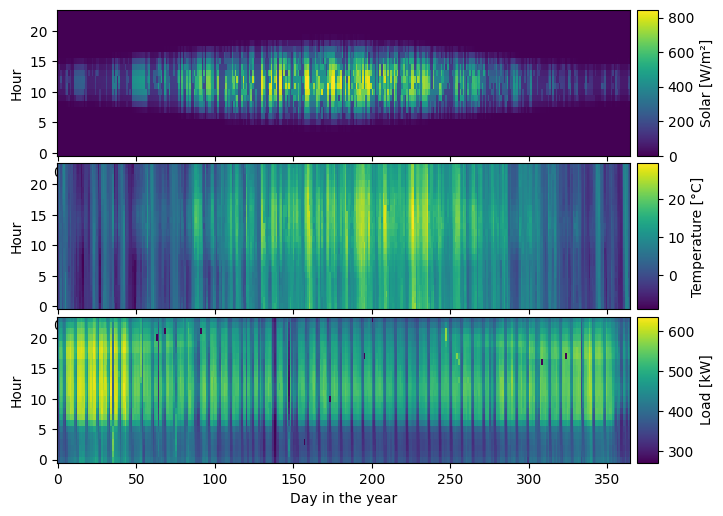

In [5]:
plotTS(raw,raw,periodlength=24)

### Tune a hierarchical aggregation with segments in combination with duration representation

In [6]:
tunedAggregations = tune.HyperTunedAggregations(
    tsam.TimeSeriesAggregation(
        raw,
        hoursPerPeriod=24,
        clusterMethod="hierarchical",
        representationMethod="durationRepresentation",
        distributionPeriodWise=False,
        rescaleClusterPeriods=False,
        segmentation=True,
    )
)

And determine the pareto optimal aggregation up to 200 total time steps. This may take some time...

In [7]:
tunedAggregations.identifyParetoOptimalAggregation(untilTotalTimeSteps=100)

112it [00:23,  4.73it/s]                        


And show the results for the last aggregation

In [8]:
predictedPeriods = tunedAggregations.aggregationHistory[-1].predictOriginalData()

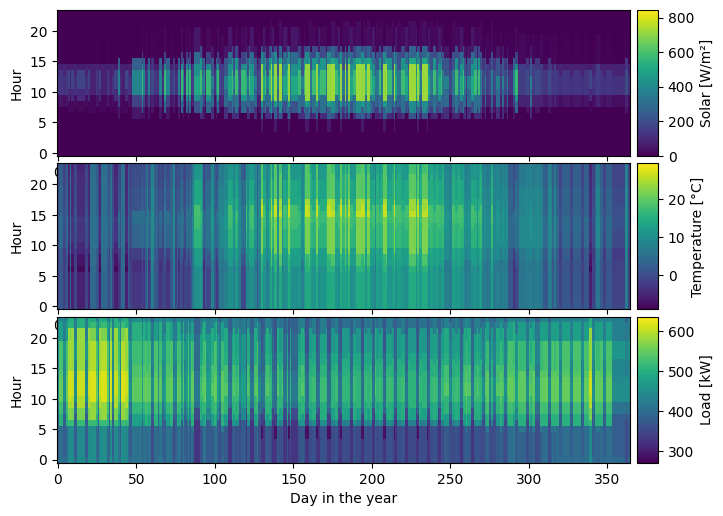

In [9]:
plotTS(predictedPeriods,raw,periodlength=24)

In [10]:
tunedAggregations._segmentHistory[-1]

8

In [11]:
tunedAggregations._periodHistory[-1]

14

In [7]:
aggregation=tsam.TimeSeriesAggregation(
        raw,
        hoursPerPeriod=24,
        noSegments=8,
        noTypicalPeriods=14,
        clusterMethod="hierarchical",
        rescaleClusterPeriods=False,
        segmentation=True,
        representationMethod="distributionAndMinMaxRepresentation",
        distributionPeriodWise=False
    )

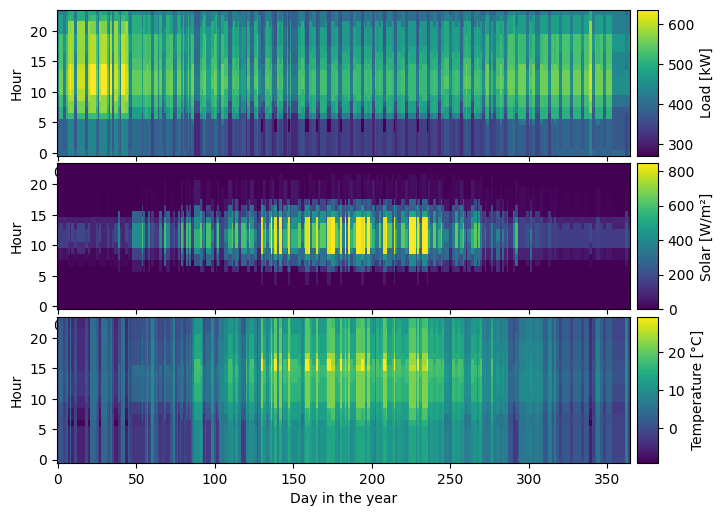

In [8]:
plotTS(aggregation.predictOriginalData(), raw,periodlength=24)